In [155]:
import pickle
import numpy as np
from load_pickle import get_outputs
from itertools import product
import matplotlib.pyplot as plt
from scipy import io
from scipy import stats
import pandas as pd
import seaborn as sns
import os

cwd = os.getcwd()

from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from utils import *

data_folder = '/Users/kendranoneman/Projects/mayo/data/neural-decoding/outpickles/'
fig_folder='/Users/kendranoneman/Projects/mayo/NeuralDecoding/figures/' 

#colors2 = ['purple', 'blue','cyan','mediumaquamarine','green','yellowgreen','gold','orange', 'magenta', 'red','gray'] #Colors to plot each method
colors = ['mediumorchid','seagreen','cornflowerblue','gold']

sessions = [18,20,22,24,28,29]

In [156]:
def get_outputs(result_dir,load_folder):
    df = pd.DataFrame() # Creates an empty list
    for file in sorted(os.listdir(data_folder+result_dir)):
        if file.endswith('.pickle'):
            with open(data_folder+result_dir+file, 'rb') as f:
                results,params_all,neurons_all,times_all = pickle.load(f)
                df1 = pd.DataFrame(results,columns=['sess','repeat','outerFold','nMT','nFEF','R2','rho'])
                df = pd.concat([df,df1],ignore_index=True)
    return df

In [214]:
DF = pd.DataFrame()
for s in sessions:
    print(s)
    data_dir = 's{:0>2d}-t0-d050-m00-o0-bn0-fo10-fi03-r0050/'.format(s)
    df = get_outputs(data_dir,data_folder)
    df['R2_norm'] = (df['R2'] - df['R2'].min()) / (df['R2'].max() - df['R2'].min())    
    DF = pd.concat([DF,df],ignore_index=True)
            
conditions = [
    (DF['nFEF'] == 0),
    (DF['nMT'] == 0),
    (DF['nMT'] > 0) | (DF['nFEF'] > 0)
    ]
values = ['mt only', 'fef only', 'mt+fef']
DF['condition'] = np.select(conditions, values)
DF['num_neurons'] = DF['nMT'] + DF['nFEF']

# display updated DataFrame
print(DF.shape)
DF.head(10)
        
#print(DF.shape)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(DF)

18
20
22
24
28
29
(531000, 10)


,sess,repeat,outerFold,nMT,nFEF,R2,rho,R2_norm,condition,num_neurons
0,18,0,0,0,2,0.001751,0.043729,0.766573,fef only,2
1,18,1,0,0,2,0.001152,0.040728,0.766060,fef only,2
2,18,2,0,0,2,0.002906,0.112175,0.767563,fef only,2
3,18,3,0,0,2,-0.002421,0.048615,0.763000,fef only,2
4,18,4,0,0,2,-0.001472,-0.017541,0.763812,fef only,2
5,18,5,0,0,2,0.001517,0.088083,0.766373,fef only,2
6,18,6,0,0,2,-0.002968,-0.010106,0.762531,fef only,2
7,18,7,0,0,2,-0.000057,0.008319,0.765025,fef only,2
8,18,8,0,0,2,0.001565,0.096881,0.766414,fef only,2
9,18,9,0,0,2,-0.000460,0.030897,0.764679,fef only,2


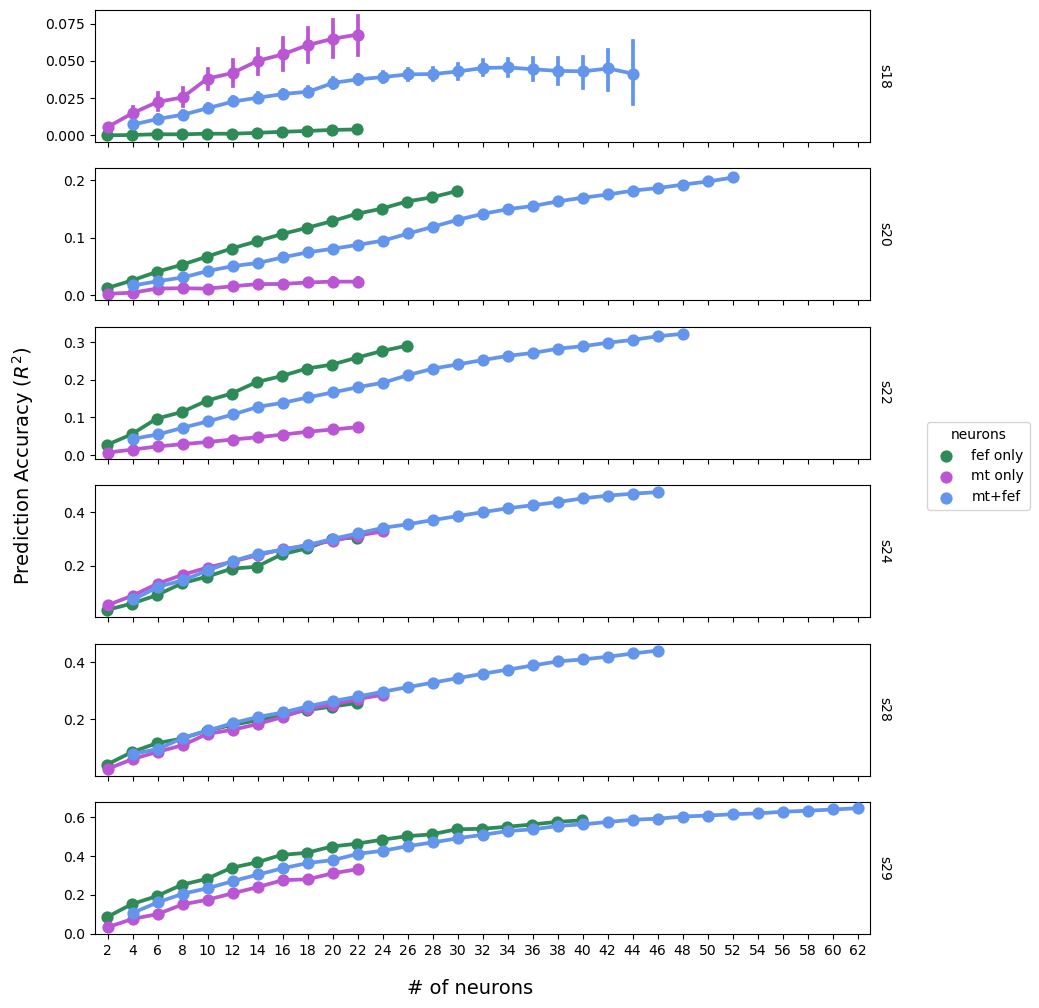

In [211]:
# POINT PLOT - MT ONLY v. FEF ONLY v. 
fig, axes = plt.subplots(len(sessions),1,figsize=(10,12),sharex=True) #Create figure (11 rows by 3 columns)
palette = {
    'mt only': colors[0],
    'fef only': colors[1],
    'mt+fef': colors[2]
}

for s in range(len(sessions)):
    df = DF.loc[DF['sess'] == sessions[s]]
    
    a = sns.pointplot(ax=axes[s],data=df,x="num_neurons",y="R2",hue="condition",errorbar='sd',dodge=True,join=True,palette=palette)
    a.set(xlabel=None)
    a.yaxis.set_label_position("right")
    a.set_ylabel('s'+str(sessions[s]),rotation=-90,labelpad=15)
    a.get_legend().remove()
    if s==0:
        fig.legend(bbox_to_anchor=(0.95,0.5), loc="center left",title='neurons')
    if s!=len(sessions)-1:
        a.set(xticklabels=[])
        
    #[a.text(p[0], p[1]+50, p[1], color='g') for p in zip(a.get_xticks(), df_c[0:10])]
    
fig.text(0.5, 0.06, '# of neurons', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Prediction Accuracy ($R^2$)', va='center', rotation='vertical', fontsize=14)

fig.savefig(fig_folder+'r2_numNeurons_6sessSep.png', dpi=300, bbox_inches='tight')

/Users/kendranoneman/miniforge3/envs/neuraldecoding/lib/python3.10/site-packages/matplotlib/text.py:1475: UserWarning: Warning: converting a masked element to nan.
  x = float(self.convert_xunits(x))
/Users/kendranoneman/miniforge3/envs/neuraldecoding/lib/python3.10/site-packages/matplotlib/text.py:1477: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))


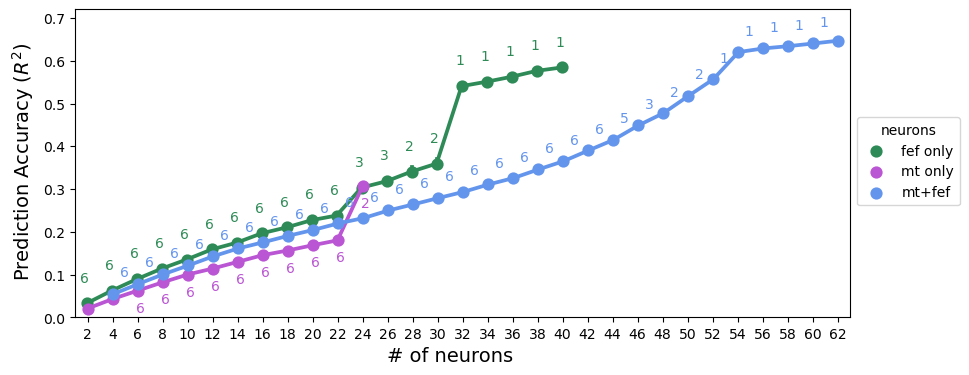

In [210]:
fig = plt.figure(figsize=(10,4))
palette = {
    'mt only': colors[0],
    'fef only': colors[1],
    'mt+fef': colors[2]
}

a = sns.pointplot(data=DF,x="num_neurons",y="R2",hue="condition",errorbar=('ci', 95),dodge=True,join=True,palette=palette)
a.set(xlabel=None)
a.set(ylabel=None)
a.set(ylim=(0, 0.72))
a.get_legend().remove()
fig.legend(bbox_to_anchor=(0.9,0.5), loc="center left",title='neurons')

df_c = DF.groupby(['condition','num_neurons','sess']).mean().reset_index()
df_c = df_c.groupby(['condition','num_neurons']).count().reset_index()
df_cnts = [df_c.loc[df_c['condition'] == 'fef only']['repeat'].values,df_c.loc[df_c['condition'] == 'mt only']['repeat'].values,df_c.loc[df_c['condition'] == 'mt+fef']['repeat'].values]

cnt = 0
for c in a.collections:
    cnt1 = 0
    for i, of in zip(range(len(c.get_offsets())), c.get_offsets()):
        if cnt1<len(df_cnts[cnt]):
            if cnt==0:
                of = of + [-0.25,0.05]
                col = colors[1]
            elif cnt==1:
                of = of + [-0.05,-0.05]
                col = colors[0]
            else:
                of = of + [0.25,0.04]
                col = colors[2]
            a.annotate(df_cnts[cnt][cnt1], of, color=col, fontsize=10)
            cnt1 += 1
    cnt += 1

fig.text(0.5, 0.001, '# of neurons', ha='center', fontsize=14)
fig.text(0.06, 0.5, 'Prediction Accuracy ($R^2$)', va='center', rotation='vertical', fontsize=14)

fig.savefig(fig_folder+'r2_numNeurons_6sess.png', dpi=300, bbox_inches='tight')

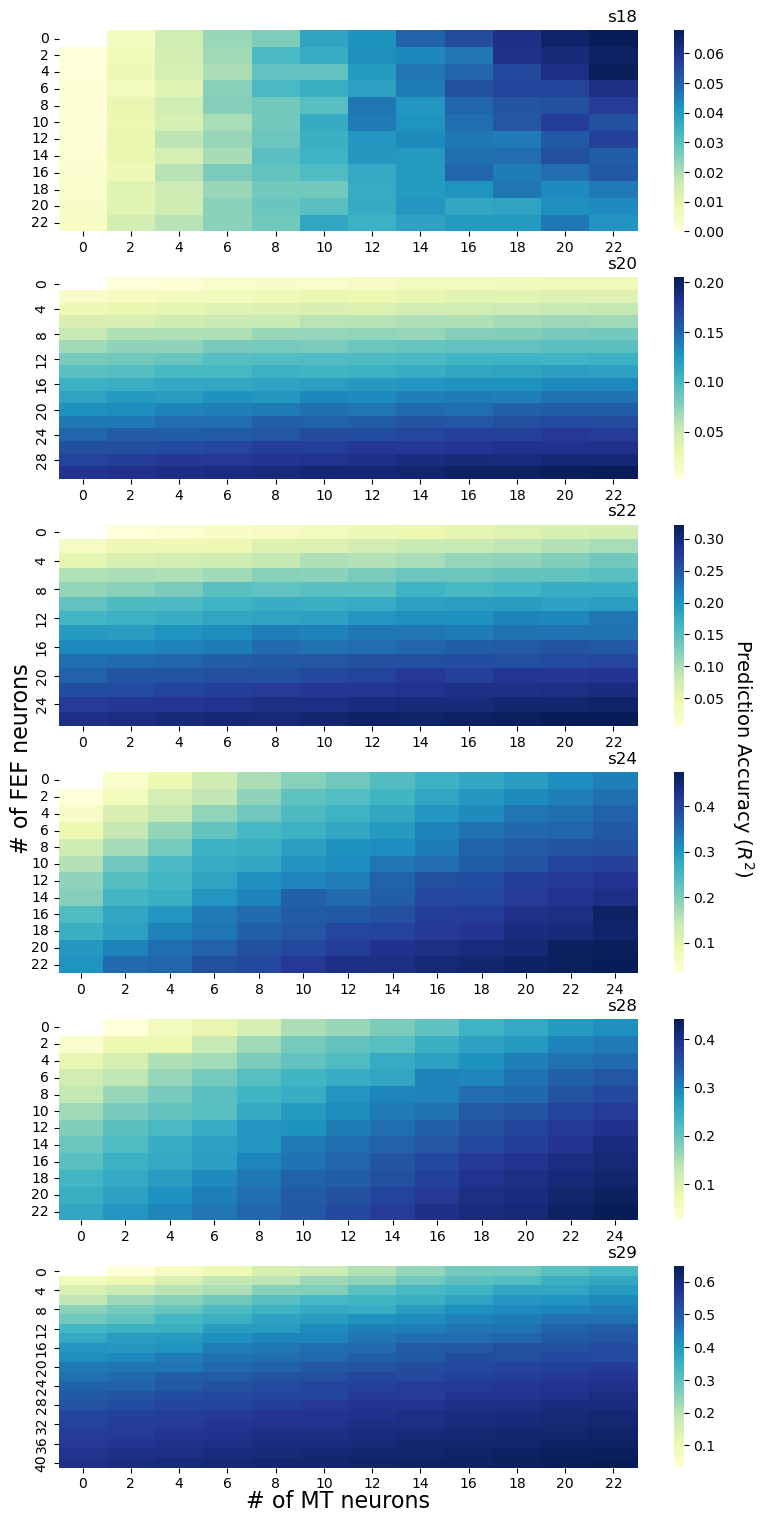

In [209]:
# 'sess','repeat','outerFold','nMT','nFEF','R2','rho'
fig, axes = plt.subplots(len(sessions),1,figsize=(8,15)) #Create figure (11 rows by 3 columns)
fig.tight_layout(pad=1.2)

for s in range(len(sessions)):
    df = DF[DF['sess']==sessions[s]]
    df = df[['nMT','nFEF','R2']]

    df_m = df.groupby(['nFEF', 'nMT'])["R2"].mean().reset_index(name="mean_R2")
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #    print(df_m)

    result = df_m.pivot(index='nFEF', columns='nMT', values='mean_R2')

    a = sns.heatmap(ax=axes[s],data=result, cmap="YlGnBu", mask=result.isnull())
    a.set(xlabel=None)
    a.set(ylabel=None)
    #a.yaxis.set_label_position("right")
    #a.set(title='s'+str(sessions[s]),loc='right')
    a.set_title('s'+str(sessions[s]),loc='right')

fig.text(0, 0.5, '# of FEF neurons', va='center', rotation='vertical', fontsize=16)
fig.text(0.9, 0.5, 'Prediction Accuracy ($R^2$)', va='center', rotation=-90, fontsize=14)
fig.text(0.41, 0, '# of MT neurons', ha='center', fontsize=16)

fig.savefig(fig_folder+'r2_numNeurons-heatmap.png', dpi=300, bbox_inches='tight') 

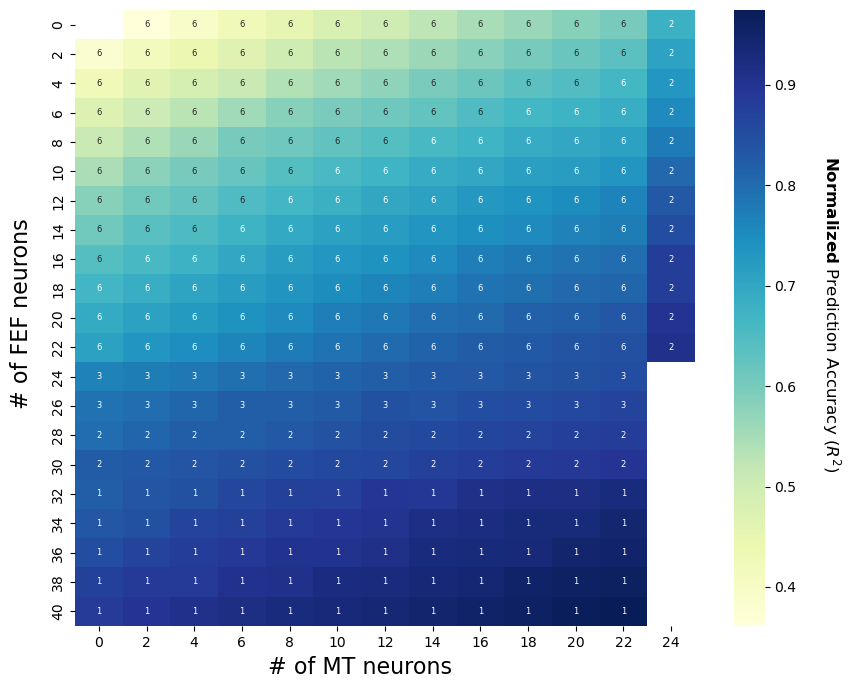

In [255]:
fig = plt.figure(figsize=(10,8))

df = DF[['nMT','nFEF','R2_norm']]
df_m = df.groupby(['nFEF', 'nMT'])["R2_norm"].mean().reset_index(name="mean_R2_norm")
df_c = df.groupby(['nFEF', 'nMT'])["R2_norm"].count().reset_index(name="mean_R2_norm")
df_c['mean_R2_norm'] = (df_c['mean_R2_norm']/500).astype('int')

result = df_m.pivot(index='nFEF', columns='nMT', values='mean_R2_norm')
result_c = df_c.pivot(index='nFEF', columns='nMT', values='mean_R2_norm')

a = sns.heatmap(data=result, cmap="YlGnBu", mask=result.isnull(),annot=result_c,annot_kws={'size': 6})
a.set(xlabel=None)
a.set(ylabel=None)

fig.text(0.06, 0.5, '# of FEF neurons', va='center', rotation='vertical', fontsize=16)
fig.text(0.87, 0.5, r'$\bf{Normalized}$'+' Prediction Accuracy ($R^2$)', va='center', rotation=-90, fontsize=12)
fig.text(0.41, 0.05, '# of MT neurons', ha='center', fontsize=16)

fig.savefig(fig_folder+'r2_numNeurons-heatmap-allSess.png', dpi=300, bbox_inches='tight') 

In [247]:
df_test = DF.loc[DF['nFEF'] >= 40]
df_test.head(100)

,sess,repeat,outerFold,nMT,nFEF,R2,rho,R2_norm,condition,num_neurons
415000,29,0,0,0,40,0.598301,0.777106,0.903975,fef only,40
415001,29,1,0,0,40,0.602882,0.781186,0.910609,fef only,40
415002,29,2,0,0,40,0.569147,0.758778,0.861752,fef only,40
415003,29,3,0,0,40,0.606576,0.781964,0.915960,fef only,40
415004,29,4,0,0,40,0.605235,0.781488,0.914017,fef only,40
...,...,...,...,...,...,...,...,...,...,...
415095,29,45,1,0,40,0.595015,0.773661,0.899217,fef only,40
415096,29,46,1,0,40,0.592476,0.772259,0.895538,fef only,40
415097,29,47,1,0,40,0.595107,0.773725,0.899349,fef only,40
415098,29,48,1,0,40,0.597799,0.775086,0.903248,fef only,40


In [ ]:
import matplotlib as mpl
import matplotlib.patheffects as path_effects

pairs = [
    [('wf', 'mt only'), ('wf', 'fef only')],
    [('wf', 'mt only'), ('wf', 'mt+fef')],
    [('wf', 'mt only'), ('wf', 'all')],
    [('wf', 'fef only'), ('wf', 'mt+fef')],
    [('wf', 'fef only'), ('wf', 'all')],
    [('wf', 'mt+fef'), ('wf', 'all')],

    [('wc', 'mt only'), ('wc', 'fef only')],
    [('wc', 'mt only'), ('wc', 'mt+fef')],
    [('wc', 'mt only'), ('wc', 'all')],
    [('wc', 'fef only'), ('wc', 'mt+fef')],
    [('wc', 'fef only'), ('wc', 'all')],
    [('wc', 'mt+fef'), ('wc', 'all')],
    
    [('dnn', 'mt only'), ('dnn', 'fef only')],
    [('dnn', 'mt only'), ('dnn', 'mt+fef')],
    [('dnn', 'mt only'), ('dnn', 'all')],
    [('dnn', 'fef only'), ('dnn', 'mt+fef')],
    [('dnn', 'fef only'), ('dnn', 'all')],
    [('dnn', 'mt+fef'), ('dnn', 'all')]
     
]

'''
[('xgb', 'mt only'), ('xgb', 'fef only')],
[('xgb', 'mt only'), ('xgb', 'mt+fef')],
[('xgb', 'fef only'), ('xgb', 'mt+fef')],

[('svr', 'mt only'), ('svr', 'fef only')],
[('svr', 'mt only'), ('svr', 'mt+fef')],
[('svr', 'fef only'), ('svr', 'mt+fef')],

[('dnn', 'mt only'), ('dnn', 'fef only')],
[('dnn', 'mt only'), ('dnn', 'mt+fef')],
[('dnn', 'fef only'), ('dnn', 'mt+fef')],

[('rnn', 'mt only'), ('rnn', 'fef only')],
[('rnn', 'mt only'), ('rnn', 'mt+fef')],
[('rnn', 'fef only'), ('rnn', 'mt+fef')],

[('gru', 'mt only'), ('gru', 'fef only')],
[('gru', 'mt only'), ('gru', 'mt+fef')],
[('gru', 'fef only'), ('gru', 'mt+fef')],

'''

fig, axes = plt.subplots(1, len(sessions), figsize=(23, 9))
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

for s in range(len(sessions)):
    with sns.plotting_context("paper", font_scale = 1.8):
        hue_plot_params = [[],[],[]]
        hue_plot_params[0] = {'data': df.loc[df['sess'] == sessions[s]],'x': 'model','y': 'r2',"hue": "Brain Area","palette": colors}
        hue_plot_params[1] = {'data': df.loc[df['sess'] == sessions[s]],'x': 'model','y': 'rho',"hue": "Brain Area","palette": colors}
        hue_plot_params[2] = {'data': df.loc[df['sess'] == sessions[s]],'x': 'model','y': 'time',"hue": "Brain Area","palette": colors}

        wf_size = int((df[(df['sess']==sessions[s]) & (df['model']=='wf')].shape[0])/4)
        wc_size = int((df[(df['sess']==sessions[s]) & (df['model']=='wc')].shape[0])/4)
        dnn_size = int((df[(df['sess']==sessions[s]) & (df['model']=='dnn')].shape[0])/4)
        print(wf_size)
        print(wc_size)
       
        a1 = sns.boxplot(ax=axes[s], **hue_plot_params[0])
        annotator = Annotator(axes[s], pairs, **hue_plot_params[0])
        annotator.configure(test="Mann-Whitney").apply_and_annotate()
        axes[s].set_xticklabels(['wf (n = {})'.format(wf_size),'wc (n = {})'.format(wc_size),'dnn (n = {})'.format(dnn_size)], rotation=0)
        a1.set(xlabel=None)
        a1.set(title='pa' + str(sessions[s])+' ({} MT, {} FEF)'.format(mt_perSess[s],fef_perSess[s]))
        
        if s==0:
            a1.set_ylabel('Prediction Accuracy ($R^2$)', fontsize = 16)
        else:
            a1.set(ylabel=None)
        
        if s!=len(sessions)-1:
            a1.get_legend().remove()
        else:    
            sns.move_legend(a1, "center left", bbox_to_anchor=(1, 0.65))  
            
fig.text(0.5, 0.01, 'model type', ha='center', fontsize=16)
fig.savefig(fig_folder+'ffmodels_r2_3sess.png', dpi=300, bbox_inches='tight')        

In [ ]:
mt_wf = df.loc[(df['Brain Area']=='mt only') & (df['model']=='wf'), "r2"].values
fef_wf =  df.loc[(df['Brain Area']=='fef only') & (df['model']=='wf'), "r2"].values
mtfef_wf = df.loc[(df['Brain Area']=='mt+fef') & (df['model']=='wf'), "r2"].values

stat_results = [
  mannwhitneyu(mt_wf, fef_wf, alternative="two-sided"),
  mannwhitneyu(fef_wf, mtfef_wf, alternative="two-sided"),
  mannwhitneyu(mt_wf, mtfef_wf, alternative="two-sided")
]

pvalues = [result.pvalue for result in stat_results]

print("MT vs FEF: \n", stat_results[0], "\n")
print("FEF vs MT+FEF: \n", stat_results[1], "\n")
print("MT vs MT+FEF: \n", stat_results[2], "\n")

In [ ]:
ts=np.arange(0,500) #Plot samples 500-800
samp = 4

fig_traces, ax = plt.subplots(3,1,figsize=(8,10)) #Create figure (11 rows by 3 columns)

m=0 #Initialize method number. This corresponds to the row we're currently plotting in.
x = (ts*50)/1000

#WF (mix FEF + MT)
ax[m].plot(x,np.array(y_test[samp])[ts,0],'k') #Plot actual
ax[m].plot(x,np.array(y_test_pred_wf[0][0])[ts,0],colors[m]) #Plot predictions, in color specified in user options section
ax[m].tick_params(direction='in') #Make ticks inward
ax[m].set_title('MT Only (R2 = {:.4f})'.format(np.mean(R2s_wf[m])))
#ax[m].set_ylim([-100,100])
#ax[m].set_yticks(np.arange(-100,100.1,50))
#ax[m].set_xlim([0,t_len]) #Set x limit
ax[m].spines['right'].set_color('none') #Remove right boundary
ax[m].spines['top'].set_color('none') #Remove top boundary
if ill:
    ax[m].set_xticklabels('')
    ax[m].set_yticklabels('')
m=m+1 

#WF (FEF only)
ax[m].plot(x,np.array(y_test[samp])[ts,0],'k') #Plot actual
ax[m].plot(x,np.array(y_test_pred_wf[1][0])[ts,0],colors[m]) #Plot predictions, in color specified in user options section
ax[m].tick_params(direction='in') #Make ticks inward
ax[m].set_title('FEF Only (R2 = {:.4f})'.format(np.mean(R2s_wf[m])))
#ax[m].set_ylim([-100,100])
#ax[m].set_yticks(np.arange(-100,100.1,50))
#ax[m].set_xlim([0,t_len]) #Set x limit
ax[m].spines['right'].set_color('none') #Remove right boundary
ax[m].spines['top'].set_color('none') #Remove top boundary
if ill:
    ax[m].set_xticklabels('')
    ax[m].set_yticklabels('')
m=m+1

#WF (MT only)
ax[m].plot(x,np.array(y_test[samp])[ts,0],'k') #Plot actual
ax[m].plot(x,np.array(y_test_pred_wf[2][0])[ts,0],colors[m]) #Plot predictions, in color specified in user options section
ax[m].tick_params(direction='in') #Make ticks inward
ax[m].set_title('MT + FEF (R2 = {:.4f})'.format(np.mean(R2s_wf[m])))
#ax[m].set_ylim([-100,100])
#ax[m].set_yticks(np.arange(-100,100.1,50))
#ax[m].set_xlim([0,t_len]) #Set x limit
ax[m].spines['right'].set_color('none') #Remove right boundary
ax[m].spines['top'].set_color('none') #Remove top boundary
if ill:
    ax[m].set_xticklabels('')
    ax[m].set_yticklabels('')
m=m+1 #Increase method index, so the next method gets plotted on the next row

